# Знакомство с TSAI

Одним из наиболее современных пакетов работы с временными рядами при помощи глубокого обучения нейронных сетей является пакет [**`TSAI`**](https://github.com/timeseriesAI/tsai), официальная документация по данному пакету может быть найдена [тут](https://timeseriesai.github.io/tsai/). 

Пакет `tsai` — это пакет глубокого обучения с открытым исходным кодом, созданный на основе фреймворков `Pytorch` и `fastai`, ориентированный на современные методы для задач временных рядов, таких как классификация, регрессия, прогнозирование, вменение.

Для установки пакета разработчиками рекомендуется следующий скрипт:
```python
stable = True # Set to True for latest pip version or False for main branch in GitHub
!pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null
```
Теперь рассмотрим импорт пакета.

In [1]:
# stable = True # Set to True for latest pip version or False for main branch in GitHub
# !pip install {"tsai -U" if stable else "git+https://github.com/timeseriesAI/tsai.git"} >> /dev/null


In [2]:
from tsai.all import *
import warnings

computer_setup()

os              : Windows-10-10.0.19045-SP0
python          : 3.11.5
tsai            : 0.3.8
fastai          : 2.7.14
fastcore        : 1.5.29
torch           : 2.1.2+cpu
device          : cpu
cpu cores       : 4
threads per cpu : 1
RAM             : 15.89 GB
GPU memory      : N/A


In [3]:
import ssl
ssl._create_default_https_context = ssl._create_stdlib_context

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
import torch
from torch import nn

Теперь давайте выберем данные. Мы будем использовать тот же пример, что и для классификации в `SKTime` - набором данных [открытые данные энергетических систем](https://open-power-system-data.org/). 

In [6]:
def extract_country(df_all, country_code, year_min=None, year_max=None):
    # List of columns to extract
    columns = [col for col in df_all.columns if col.startswith(country_code)]
    # Extract columns and remove country codes from column labels
    columns_map = {col : col[3:] for col in columns}
    df_out = df_all[columns].rename(columns=columns_map)
    # Exclude years outside of specified range, if any
    if year_min is not None:
        df_out = df_out[df_out.index.year >= year_min]
    if year_max is not None:
        df_out = df_out[df_out.index.year <= year_max]
    return df_out

def transform_dataframe(df, cols_map):
    # Rename columns for convenience
    df = df[list(cols_map.keys())].rename(columns=cols_map)    
    df = df / 1000 # Convert from MW to GW
    df = df.rename_axis('Date')
    return df

def split_by_month(df, months):
    df_ = pd.DataFrame()
    for month in np.atleast_1d(months):        
        df_ = pd.concat([df_,df.loc[df.index.month == month]])
    return df_

def to_segments(df, column, size = 24):  
    df.index.hour[0]
    start_idx = 24-df.index.hour[0]
    df = df.iloc[start_idx:]
    val = df[[column]].values
    return val[:size*(val.size//size)].reshape(-1,size)

In [7]:
url = 'https://data.open-power-system-data.org/time_series/2020-10-06/'
datafile = url + 'time_series_60min_singleindex.csv'
df_all = pd.read_csv(datafile, index_col='utc_timestamp', parse_dates=True, low_memory=False)

df_hrly = extract_country(df_all, country_code='DE', year_min=2015, year_max=2019)

df_hrly.sample(3)

cols_map = {'load_actual_entsoe_transparency' : 'Consumption',
            'wind_generation_actual' : 'Wind',
            'solar_generation_actual' : 'Solar'}
df = transform_dataframe(df_hrly, cols_map).dropna()

# df wind + solar generation
df['Wind+Solar'] = df[['Wind', 'Solar']].sum(axis=1, skipna=False)
df.to_csv('de_clf_data.csv')
df.head()

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2015-01-01 07:00:00+00:00,41.133,10.208,0.071,10.279
2015-01-01 08:00:00+00:00,42.963,10.029,0.773,10.802
2015-01-01 09:00:00+00:00,45.088,10.550,2.117,12.667
2015-01-01 10:00:00+00:00,47.013,11.390,3.364,14.754
2015-01-01 11:00:00+00:00,48.159,12.103,4.198,16.301


In [8]:
winter = to_segments(split_by_month(df, [1,2, 12]), 'Consumption', size = 24)
summer = to_segments(split_by_month(df, [6, 7, 8]), 'Consumption', size = 24)
autumn = to_segments(split_by_month(df, [9,10,11]), 'Consumption', size = 24)
spring = to_segments(split_by_month(df, [3, 4, 5]), 'Consumption', size = 24)
print(winter.shape, summer.shape, autumn.shape, spring.shape)

X = np.concatenate((
                    winter, 
                    summer, 
                    autumn, 
                    spring))
y = np.concatenate((
                    1*np.ones(winter.shape[0]),
                    2*np.ones(summer.shape[0]),
                    3*np.ones(autumn.shape[0]),
                    4*np.ones(spring.shape[0])
                   ))


X = np.atleast_3d(X).transpose(0,2,1)
y.astype(int)

(448, 24) (458, 24) (452, 24) (458, 24)


array([1, 1, 1, ..., 4, 4, 4])

Также давайте сопоставим названия классов и их номера для большего удобства.

In [9]:
class_map = {
    1:'winter',   
    2:'summer',   
    3:'autumn',   
    4:'spring',   
    }
class_map

labeler = ReLabeler(class_map)
y = labeler(y) 

Особенностью данного фреймворка (как и его основы `fastai`) является использование супер высокоуровневых API. Это делает фреймворк `tsai` практически декларативным. Для проведения экспериментом нам потребуется лишь выбор модели и набора данных. Все обучение будет происходить в `backend`.

Для работы с наборами данных давайте создадим их разделение на тренировочную, валидационную и тестовую подвыборки. Для этого воспользуемся функцией `get_splits`. В рамках урока мы задаем аргумент `show_plot` чтобы визуализировать разделение данных.

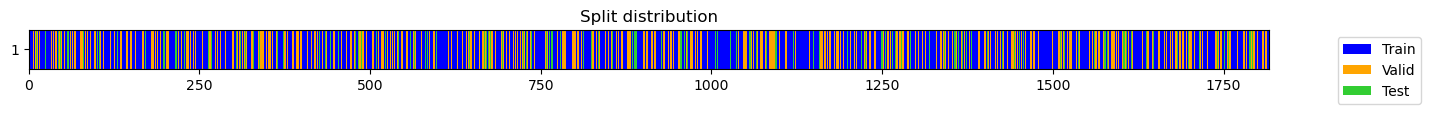

((#1091) [1274,358,488,1233,469,725,151,1202,1173,894...],
 (#544) [1783,1159,952,1712,203,45,563,1071,1640,868...],
 (#181) [690,310,767,645,80,673,451,597,927,1404...])

In [10]:
splits = get_splits(y, 
                    n_splits=1, 
                    valid_size=0.3, 
                    test_size=0.1, 
                    shuffle=True, 
                    balance=False, 
                    stratify=True,
                    random_state=42, 
                    show_plot=True, 
                    verbose=True)
splits



Для начала давайте создадим набор данных. Такой набор будет экземпляром класса `TSDatasets`. В наборе данных зададим разделение данных и необходимые преобразования `tfms`.

Также сконфигурируем загрузчик батчей `TSDataLoaders`. Загрузим тренировочный и валидационный наборы данных.

In [11]:
tfms  = [None, [Categorize()]]
dsets = TSDatasets(X, y, tfms=tfms, splits=splits)
 
bs = 256
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=[bs, bs*2])


Среди анализируемых архитектур мы рассмотрим рекуррентные `RNN`, `LSTM` и `GRU` ячейки в двух вариантах обычном и плюс. Варианты несколько отличаются по архитектуре. Для обоих вариантов мы рассмотрим архитектуры с 3 и 4 слоями, как двунаправленные, так и нет.

Кроме рекуррентных нейронных сетей мы также попробуем ряд стандартных сверточных архитектур, таких как `ResNet1d`, `xresnet1d`, `InceptionTime `, `XceptionTime` и `TCN`. Данные архитектуры представляют собой стандартные подходы к классификации временных рядов нейронными сетями. Последняя архитектура представляет собой использование идеи расширенной свертки. архитектуры `ResNet1d` и `xresnet1d` отличаются подходом к организации `skipconnection`. Архитектуры `InceptionTime ` и `XceptionTime` представляют собой адаптированные под временные ряды соответствующих сверточных сетей для изображений. Также, для сравнения, мы попробуем использовать смешанную архитектуру `LSTM_FCN`, полносвязную архитектуру FCN и архитектуру трансформер `TST`.

Отметим, что почти все архитектуры в нашем примере мы вызываем "из коробки", подробней с реализациями данных архитектур можно ознакомится в рамках официальной документации. 

In [12]:
archs = [
         (RNNPlus, {'n_layers':3, 'bidirectional': True} ),
         (LSTMPlus,{'n_layers':3, 'bidirectional': True} ),
         (GRUPlus, {'n_layers':3, 'bidirectional': True} ),   
         (RNNPlus, {'n_layers':4, 'bidirectional': True} ),
         (RNNPlus, {'n_layers':4, 'bidirectional': False}),  
         (LSTM,    {'n_layers':3, 'bidirectional': False}), 
         (RNN,     {'n_layers':3, 'bidirectional': True} ), 
         (LSTM,    {'n_layers':3, 'bidirectional': True} ),
         (GRU,     {'n_layers':3, 'bidirectional': True} ),   
         (ResNet, {}), 
         (xresnet1d34, {}), 
         (xresnet1d50_deeper, {}), 
         (InceptionTime, {}), 
         (XceptionTime,  {}), 
         (TCN, {}),   
         (LSTM_FCN, {}), 
         (TST, {}),
         (FCN, {}),   
        ]

Теперь попробуем запустить обучение. 
Для создания модели используем функцию `create_model`, которая для создает модель в формате совместимом с `PyTorch` для заданной архитектуры и набора гиперпараметров.

В пакете `tsai` обучение проводится для объекта класса `Learner`. Таким образом этот класс описывает модель (обученную архитектуру). Мы приведем лишь самую простую конфигурацию этого класса. Конфигурация включает указание загрузчика данных, модели и метрики. В качестве метрики мы используем точность (`accuracy`). Для запуска обучения в классе `Learner` используется метод `fit_one_cycle`. Для этого метода в качестве параметров мы зададим число эпох обучения и скорость обучения. Остальные параметры оставим по умолчанию. Среди таких параметров будут функция потерь (кросс энтропия) и метод оптимизации `ADAM`. 

По результатам обучения каждой модели мы занесем в таблицу полученные результаты, в том числе точность для валидационного набора данных и время обучения.

In [13]:
from IPython.display import clear_output



results = pd.DataFrame(columns=['arch', 'hyperparams', 'total params', 'train loss', 'valid loss', 'accuracy', 'time'])

for i, (arch, k) in enumerate(archs):
   
    model = create_model(arch, dls=dls, **k)
    
    print(model.__class__.__name__)
    
    learn = Learner(dls, model,  metrics=accuracy)
    start = time.time()
    learn.fit_one_cycle(20, 1e-3)
    elapsed = time.time() - start
    vals = learn.recorder.values[-1]
    results.loc[i] = [arch.__name__, k, count_parameters(model), vals[0], vals[1], vals[2], int(elapsed)]
    results.sort_values(by='accuracy', ascending=False, ignore_index=True, inplace=True)
    clear_output()
    display(results)

,arch,hyperparams,total params,train loss,valid loss,accuracy,time
0,ResNet,{},478724,0.267138,0.152218,0.948529,36
1,RNNPlus,"{'n_layers': 4, 'bidirectional': True}",202604,0.810778,0.484506,0.847426,25
2,RNNPlus,"{'n_layers': 4, 'bidirectional': False}",71304,0.846607,0.558817,0.823529,11
3,RNNPlus,"{'n_layers': 3, 'bidirectional': True}",142204,0.773726,0.507577,0.818015,22
4,RNN,"{'n_layers': 3, 'bidirectional': True}",142204,0.857691,0.553927,0.806985,16
5,LSTM,"{'n_layers': 3, 'bidirectional': True}",566404,1.005659,0.834670,0.648897,30
6,GRU,"{'n_layers': 3, 'bidirectional': True}",425004,1.076247,0.901788,0.615809,56
7,GRUPlus,"{'n_layers': 3, 'bidirectional': True}",425004,1.040403,0.884069,0.613971,71
8,LSTMPlus,"{'n_layers': 3, 'bidirectional': True}",566404,1.055473,0.887719,0.602941,43
9,LSTM,"{'n_layers': 3, 'bidirectional': False}",203204,1.088806,0.964918,0.518382,12


TypeError: Conv1d.__init__() got an unexpected keyword argument 'seq_len'

Среди полученных результатов хотелось бы выделить `RNNPlus`. Эта архитектура дала результат, оптимальный по соотношению точности и времени работы. Давайте рассмотрим эту архитектуру подробней

In [14]:
arch = RNNPlus
k = {'n_layers': 4, 'bidirectional': True}
model = create_model(arch, dls=dls, **k)

In [15]:
model = build_ts_model(RNNPlus, arch_config=k, dls=dls)

Фреймворк `tsai` предлагает метод определения оптимальной скорости обучения на основе тестов нескольких эпох обучения. Попробуем определить лучшую скорость обучения.

SuggestedLRs(valley=6.30957365501672e-05)

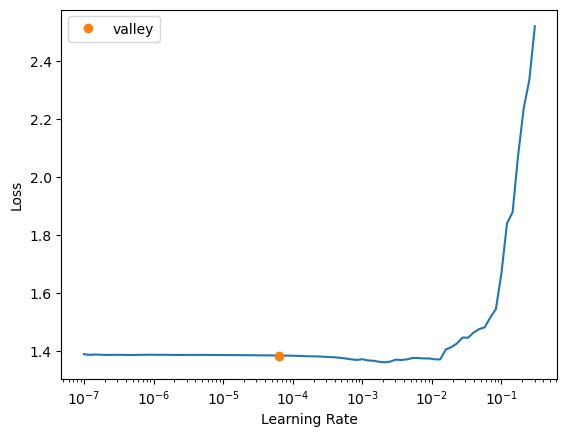

In [16]:
learn = ts_learner(dls, arch=model, metrics=accuracy) 
learn.lr_find()

Теперь снова запустим обучение. В этот раз мы запустим процедуру тренировки с коллбеком, позволяющим отслеживать значения функций потерь в режиме он-лайн.

epoch,train_loss,valid_loss,accuracy,time
0,1.387884,1.386290,0.250000,00:01
1,1.386808,1.385484,0.250000,00:01
2,1.385997,1.384624,0.250000,00:01
3,1.385392,1.383642,0.253676,00:01
4,1.384890,1.382555,0.266544,00:01
5,1.384335,1.381300,0.231618,00:01
6,1.383692,1.379624,0.213235,00:01
7,1.382968,1.377206,0.294118,00:01
8,1.382042,1.374025,0.305147,00:01
9,1.380875,1.370488,0.356618,00:01


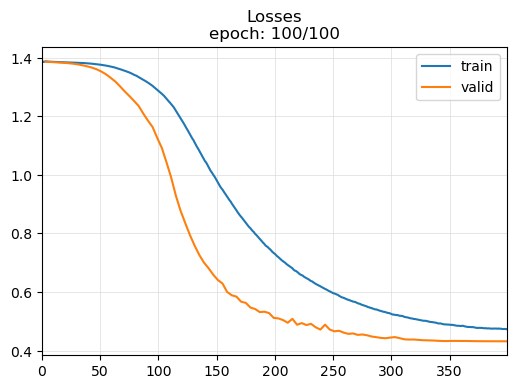

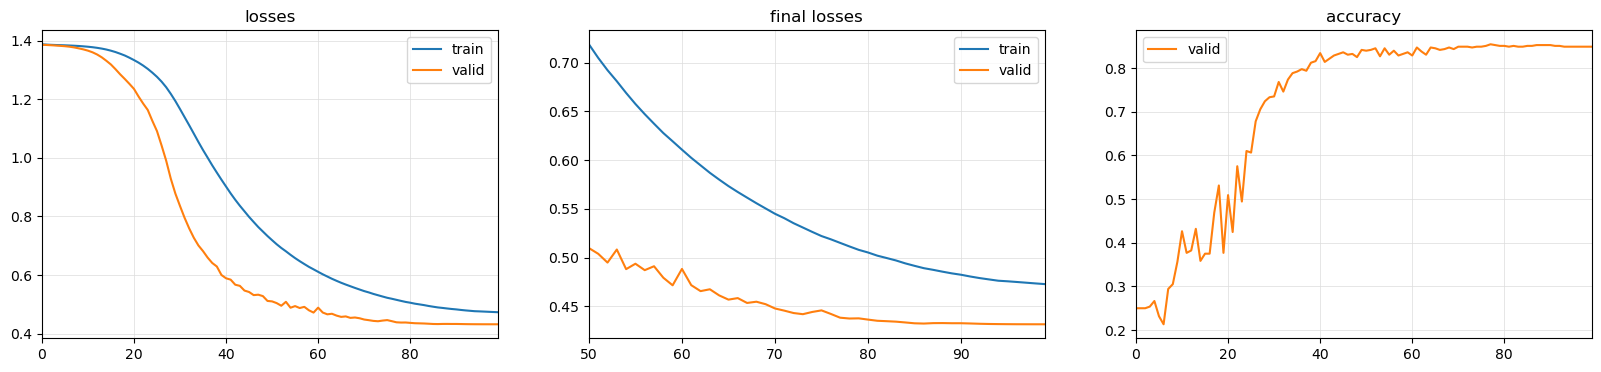

In [17]:
learn = Learner(dls, model,  metrics=accuracy)
start = time.time()
learn.fit_one_cycle(n_epoch = 100, lr_max = 0.00009, cbs=ShowGraph())




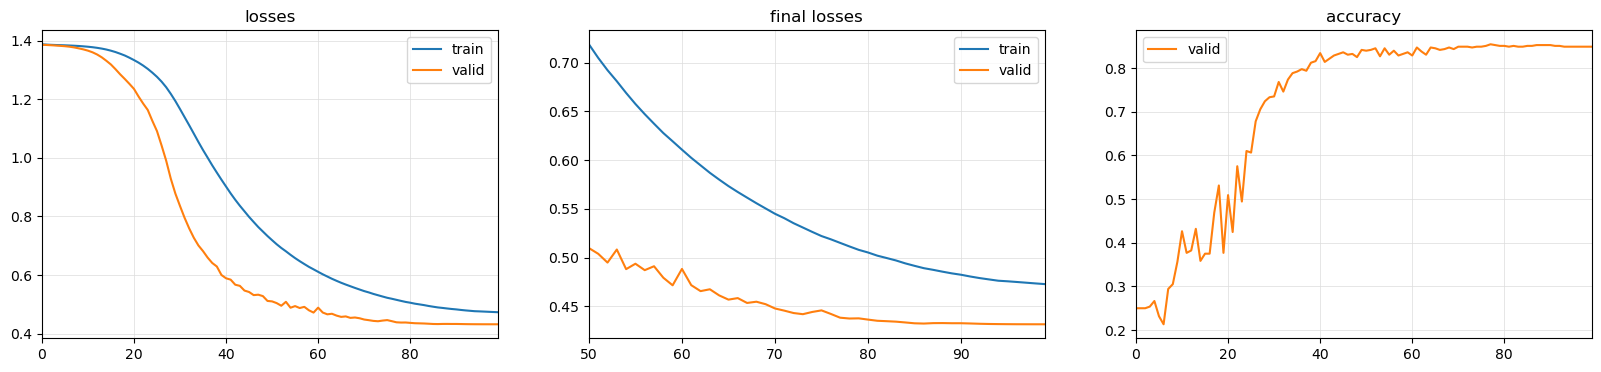

In [18]:
learn.plot_metrics()

Рассмотрим несколько примеров результатов для валидационного набора данных.

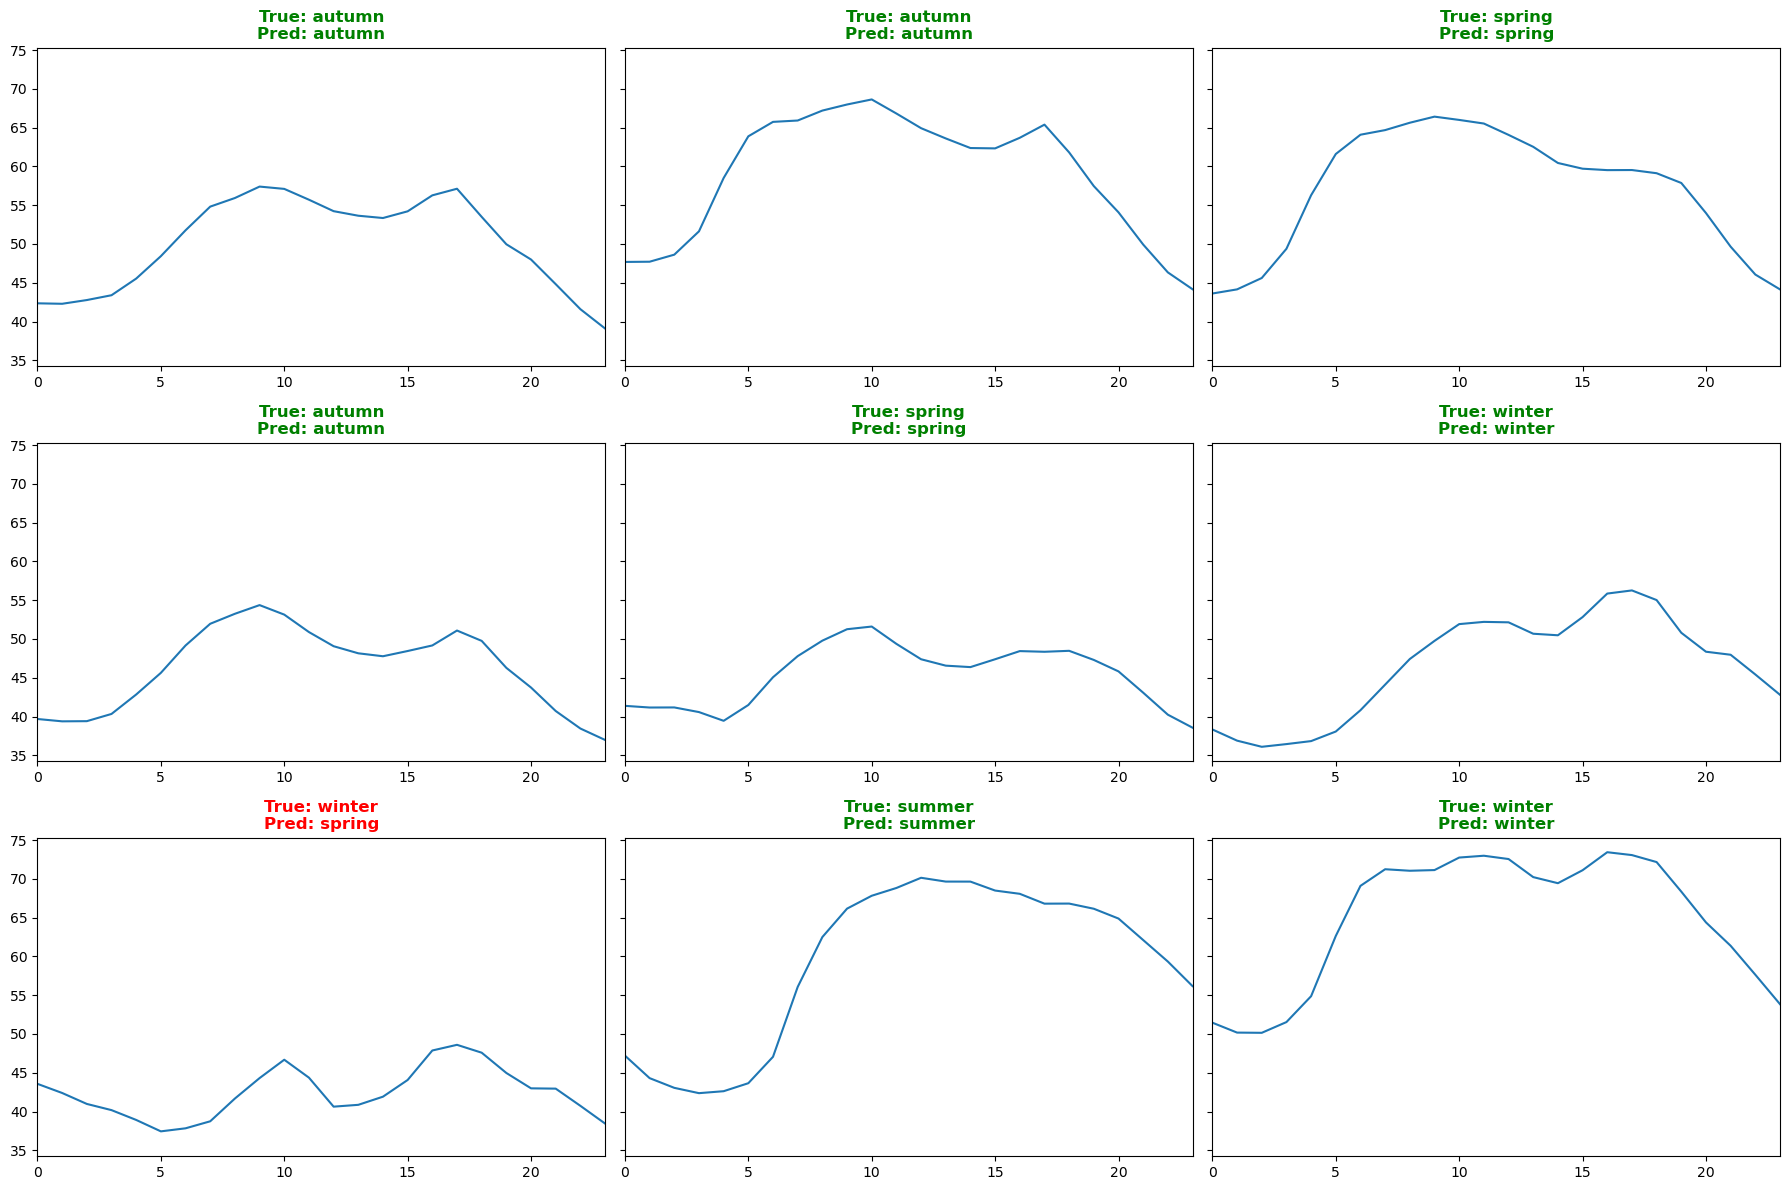

In [19]:
learn.show_results(sharey=True)

Также давайте попробуем визуализировать результаты. Следующий график показывает вероятность при которой определяется класс для каждого семпла валидационной выборки.

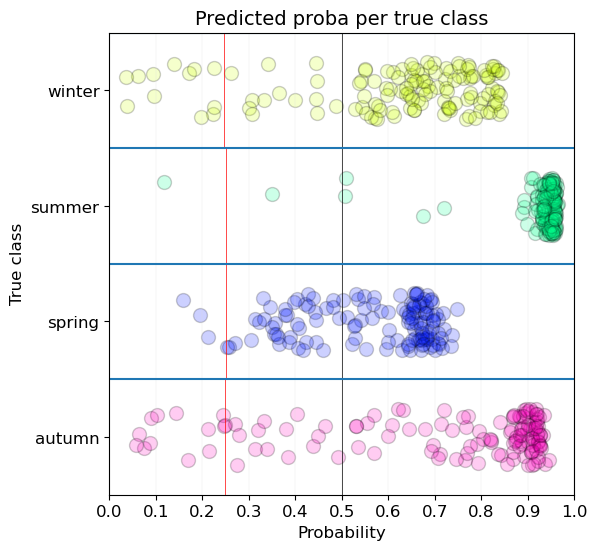

In [20]:
learn.show_probas()

Также для анализа ошибок давайте посмотрим на матрицу ошибок.

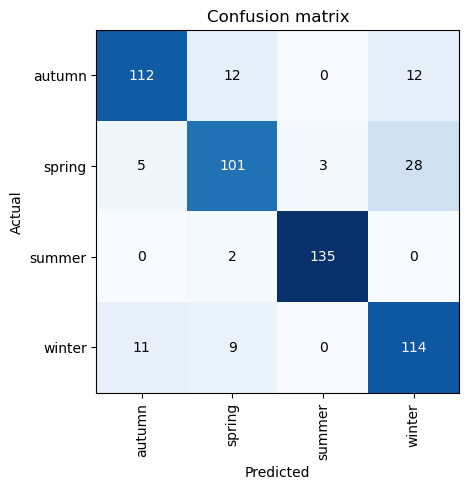

In [21]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Выберем из матрицы наиболее ошибочные случаи.

In [22]:
interp.most_confused(min_val=3)

[('spring', 'winter', 28),
 ('autumn', 'spring', 12),
 ('autumn', 'winter', 12),
 ('winter', 'autumn', 11),
 ('winter', 'spring', 9),
 ('spring', 'autumn', 5),
 ('spring', 'summer', 3)]

Помимо прочего попробуем сделать предсказания для тестового набора данных.

In [23]:
probas, _, preds = learn.get_X_preds(X[splits[2][:5]])
preds, y[splits[2][:5]]

("['summer', 'winter', 'summer', 'summer', 'winter']",
 array(['summer', 'winter', 'summer', 'summer', 'winter'], dtype='<U6'))

Оценим точность на тестовом наборе данных

In [24]:
probas, _, preds = learn.get_X_preds(X[splits[2]])

In [25]:
class_map = {
    'winter':3,   
    'summer':2,   
    'autumn':0,   
    'spring':1,  
    }
class_map

labeler = ReLabeler(class_map)

In [26]:
from sklearn.metrics import accuracy_score

accuracy_score(np.argmax(probas,axis=-1), labeler(y[splits[2]]))


0.8066298342541437

также покажем возможность сохранить и загрузить наборы данных при помощи `tsai`.

In [27]:
learn.save_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner')

In [28]:
learn = load_learner_all(path='export', dls_fname='dls', model_fname='model', learner_fname='learner')
dls = learn.dls

In [29]:
probas, _, preds = learn.get_X_preds(X[splits[2][:5]])
preds, y[splits[2][:5]]

("['summer', 'winter', 'summer', 'summer', 'winter']",
 array(['summer', 'winter', 'summer', 'summer', 'winter'], dtype='<U6'))

Больше информации по работе с фреймворком `tsai` можно получить в разделе уроки в рамках [официального репозитория](https://github.com/timeseriesAI/tsai/tree/main/tutorial_nbs) или [документации](https://timeseriesai.github.io/tsai/tutorials.html).